## Constant from IV-characteristics : <font color = 'sky blue'> $n_e, T_e, T_-, I_{sat+}$ </font>
<font size="2">
    [1] <a href="https://sci-hub.se/https://aip.scitation.org/doi/10.1063/1.4802252"> [2013] Langmuir probe analysis of highly electronegative plasmas</a> <br>
    [2] <a href="https://sci-hub.se/https://doi.org/10.1063/1.4903328"> [2014] Langmuir probe analysis in electronegative plasmas</a> <br>
    [3] <a href="https://sci-hub.se/https://doi.org/10.1063/1.874162"> [2000] How big is a small Langmuir probe?</a> <br>
    [4] <a href="https://sci-hub.se/10.1088/0022-3727/43/10/105204"> [2010] The plasma sheath around large discs and ion collection by planar Langmuir probes</a> <br>

In [23]:
import numpy as np
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt
import importlib

from scipy.integrate import simpson
from scipy.integrate import odeint

from const import *
import ldf
import plotting
import method

importlib.reload(plotting)
importlib.reload(ldf)
importlib.reload(method)

<module 'method' from 'c:\\Users\\GUNU\\Desktop\\negative-ion\\method.py'>

./211216(SF6)/bias (GND)/0.ldf


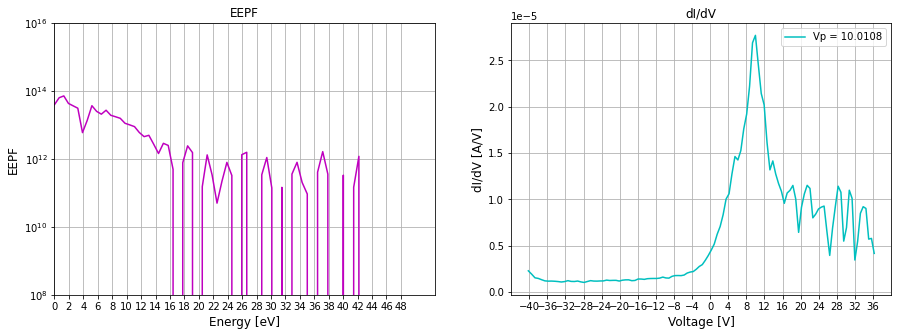

Enter limited energy
ne: 3.222e+14 [m-3]	 Te: 11.852 [eV] 	 V_lim: 14.0
a_0: 3.0000	 a_s: 0.2275	 gamma: 118.5214	 sol_number: 2
J: 3.13e+01	 uB: 626.487	 r_sh: 2.59e-04	
-------------------------------------------------------
a_0: 1613.9239	 a_s: 0.0402	 gamma: 118.5214	 sol_number: 2
J: 1.21e+01	 uB: 1270.204	 r_sh: 3.59e-04	
-------------------------------------------------------
a_0: 306.8520	 a_s: 0.0515	 gamma: 118.5214	 sol_number: 2
J: 8.73e+00	 uB: 1150.419	 r_sh: 3.91e-04	
-------------------------------------------------------
a_0: 244.3070	 a_s: 0.0536	 gamma: 118.5214	 sol_number: 2
J: 8.01e+00	 uB: 1131.909	 r_sh: 4.01e-04	
-------------------------------------------------------
a_0: 227.6650	 a_s: 0.0542	 gamma: 118.5214	 sol_number: 2
J: 7.81e+00	 uB: 1126.795	 r_sh: 4.03e-04	
-------------------------------------------------------
a_0: 223.1122	 a_s: 0.0544	 gamma: 118.5214	 sol_number: 2
J: 7.76e+00	 uB: 1125.107	 r_sh: 4.04e-04	
--------------------------------------

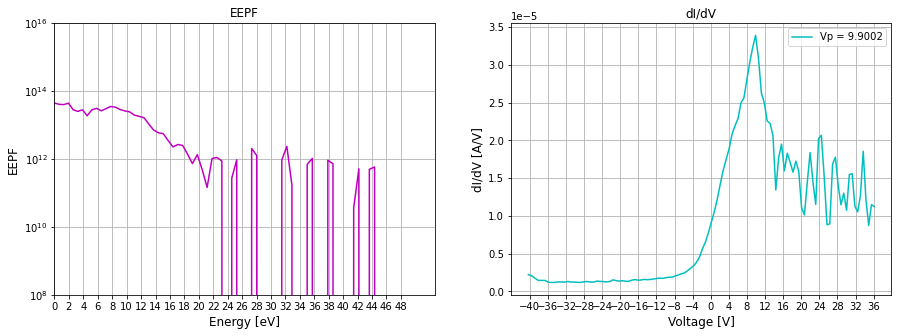

Enter limited energy
ne: 3.937e+14 [m-3]	 Te: 18.387 [eV] 	 V_lim: 20.0
a_0: 3.0000	 a_s: 0.2368	 gamma: 183.8703	 sol_number: 2
J: 3.40e+01	 uB: 620.623	 r_sh: 2.54e-04	
-------------------------------------------------------
a_0: 1446.4143	 a_s: 0.0446	 gamma: 183.8703	 sol_number: 2
J: 1.34e+01	 uB: 1254.938	 r_sh: 3.48e-04	
-------------------------------------------------------
a_0: 281.3261	 a_s: 0.0562	 gamma: 183.8703	 sol_number: 2
J: 9.76e+00	 uB: 1136.964	 r_sh: 3.78e-04	
-------------------------------------------------------
a_0: 226.1994	 a_s: 0.0582	 gamma: 183.8703	 sol_number: 2
J: 8.99e+00	 uB: 1120.014	 r_sh: 3.87e-04	
-------------------------------------------------------
a_0: 211.3436	 a_s: 0.0589	 gamma: 183.8703	 sol_number: 2
J: 8.78e+00	 uB: 1114.273	 r_sh: 3.89e-04	
-------------------------------------------------------
a_0: 207.5089	 a_s: 0.0591	 gamma: 183.8703	 sol_number: 2
J: 8.72e+00	 uB: 1112.650	 r_sh: 3.90e-04	
--------------------------------------

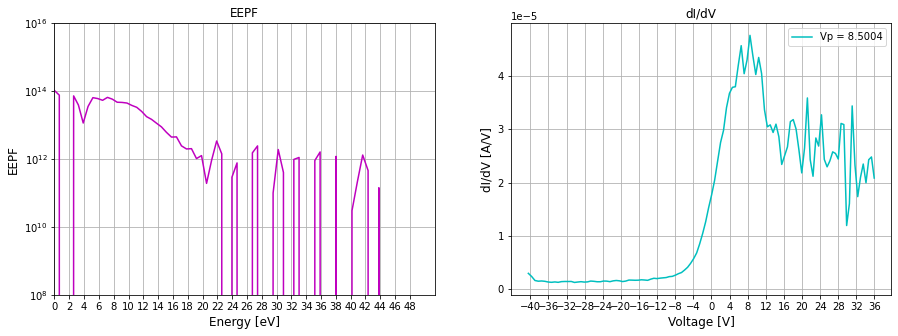

Enter limited energy
ne: 5.577e+14 [m-3]	 Te: 19.160 [eV] 	 V_lim: 20.0
a_0: 3.0000	 a_s: 0.2374	 gamma: 191.6019	 sol_number: 2
J: 3.80e+01	 uB: 620.287	 r_sh: 2.47e-04	
-------------------------------------------------------
a_0: 1141.7249	 a_s: 0.0462	 gamma: 191.6019	 sol_number: 2
J: 1.54e+01	 uB: 1238.924	 r_sh: 3.34e-04	
-------------------------------------------------------
a_0: 230.7881	 a_s: 0.0583	 gamma: 191.6019	 sol_number: 2
J: 1.14e+01	 uB: 1121.120	 r_sh: 3.61e-04	
-------------------------------------------------------
a_0: 188.3596	 a_s: 0.0603	 gamma: 191.6019	 sol_number: 2
J: 1.05e+01	 uB: 1104.918	 r_sh: 3.69e-04	
-------------------------------------------------------
a_0: 176.8418	 a_s: 0.061	 gamma: 191.6019	 sol_number: 2
J: 1.03e+01	 uB: 1099.425	 r_sh: 3.71e-04	
-------------------------------------------------------
a_0: 173.9331	 a_s: 0.0611	 gamma: 191.6019	 sol_number: 2
J: 1.02e+01	 uB: 1098.648	 r_sh: 3.71e-04	
---------------------------------------

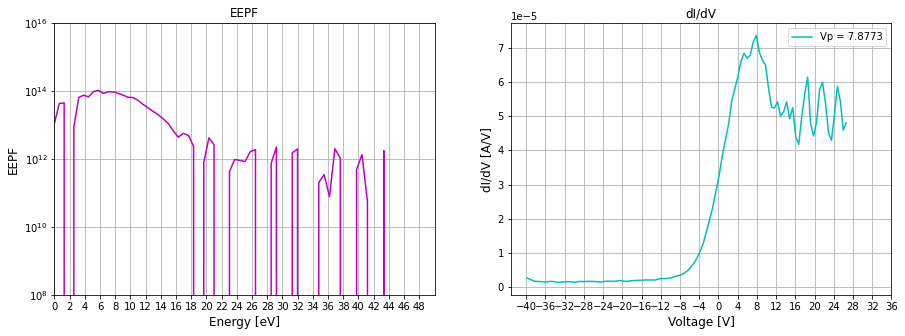

Enter limited energy
ne: 8.339e+14 [m-3]	 Te: 19.942 [eV] 	 V_lim: 18.0
a_0: 3.0000	 a_s: 0.2381	 gamma: 199.4188	 sol_number: 2
J: 4.28e+01	 uB: 619.830	 r_sh: 2.38e-04	
-------------------------------------------------------
a_0: 860.7028	 a_s: 0.0483	 gamma: 199.4188	 sol_number: 2
J: 1.79e+01	 uB: 1217.923	 r_sh: 3.17e-04	
-------------------------------------------------------
a_0: 182.9630	 a_s: 0.0609	 gamma: 199.4188	 sol_number: 2
J: 1.35e+01	 uB: 1101.911	 r_sh: 3.40e-04	
-------------------------------------------------------
a_0: 151.9176	 a_s: 0.0629	 gamma: 199.4188	 sol_number: 2
J: 1.26e+01	 uB: 1086.587	 r_sh: 3.47e-04	
-------------------------------------------------------
a_0: 143.4708	 a_s: 0.0635	 gamma: 199.4188	 sol_number: 2
J: 1.23e+01	 uB: 1082.124	 r_sh: 3.49e-04	
-------------------------------------------------------
a_0: 141.3046	 a_s: 0.0637	 gamma: 199.4188	 sol_number: 2
J: 1.23e+01	 uB: 1080.650	 r_sh: 3.49e-04	
---------------------------------------

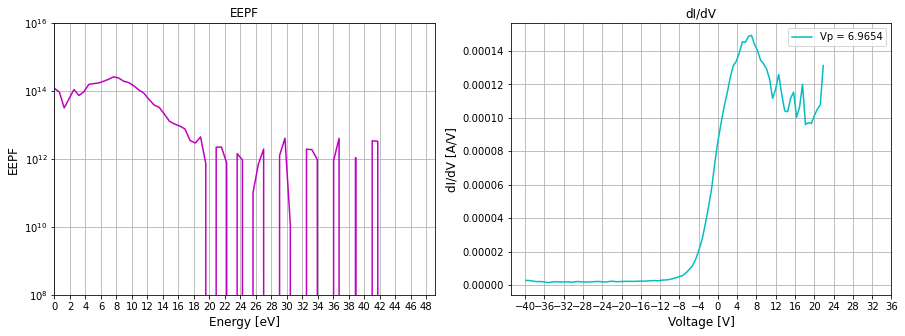

Enter limited energy
ne: 1.819e+15 [m-3]	 Te: 18.682 [eV] 	 V_lim: 18.0
a_0: 3.0000	 a_s: 0.237	 gamma: 186.8210	 sol_number: 2
J: 5.18e+01	 uB: 620.527	 r_sh: 2.28e-04	
-------------------------------------------------------
a_0: 476.9446	 a_s: 0.052	 gamma: 186.8210	 sol_number: 2
J: 2.28e+01	 uB: 1176.334	 r_sh: 2.95e-04	
-------------------------------------------------------
a_0: 109.7364	 a_s: 0.0662	 gamma: 186.8210	 sol_number: 2
J: 1.75e+01	 uB: 1060.245	 r_sh: 3.14e-04	
-------------------------------------------------------
a_0: 93.6752	 a_s: 0.0682	 gamma: 186.8210	 sol_number: 2
J: 1.65e+01	 uB: 1046.711	 r_sh: 3.19e-04	
-------------------------------------------------------
a_0: 89.1509	 a_s: 0.0688	 gamma: 186.8210	 sol_number: 2
J: 1.62e+01	 uB: 1042.761	 r_sh: 3.21e-04	
-------------------------------------------------------
a_0: 88.0376	 a_s: 0.069	 gamma: 186.8210	 sol_number: 2
J: 1.61e+01	 uB: 1041.455	 r_sh: 3.21e-04	
---------------------------------------------

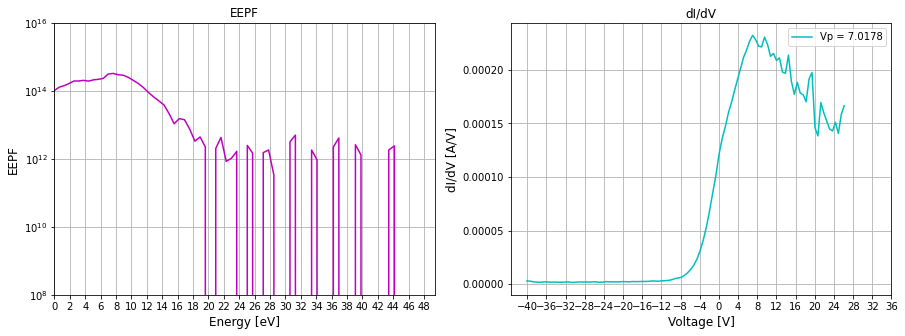

Enter limited energy
ne: 2.738e+15 [m-3]	 Te: 18.086 [eV] 	 V_lim: 18.0
a_0: 3.0000	 a_s: 0.2365	 gamma: 180.8609	 sol_number: 2
J: 6.01e+01	 uB: 620.816	 r_sh: 2.20e-04	
-------------------------------------------------------
a_0: 367.4760	 a_s: 0.0538	 gamma: 180.8609	 sol_number: 2
J: 2.73e+01	 uB: 1157.564	 r_sh: 2.81e-04	
-------------------------------------------------------
a_0: 88.7041	 a_s: 0.0686	 gamma: 180.8609	 sol_number: 2
J: 2.14e+01	 uB: 1042.829	 r_sh: 2.98e-04	
-------------------------------------------------------
a_0: 76.9800	 a_s: 0.01	 gamma: 180.8609	 sol_number: 5
J: 2.02e+01	 uB: 2215.069	 r_sh: 3.34e-04	
-------------------------------------------------------
a_0: 33.7091	 a_s: 0.0845	 gamma: 180.8609	 sol_number: 2
J: 1.80e+01	 uB: 953.286	 r_sh: 3.09e-04	
-------------------------------------------------------
a_0: 70.8972	 a_s: 0.0718	 gamma: 180.8609	 sol_number: 2
J: 1.94e+01	 uB: 1022.552	 r_sh: 3.05e-04	
----------------------------------------------

C:\Users\GUNU\anaconda3\envs\pyrl\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


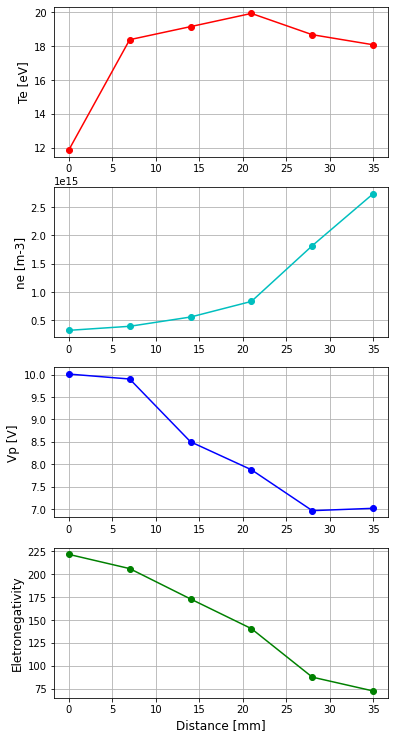

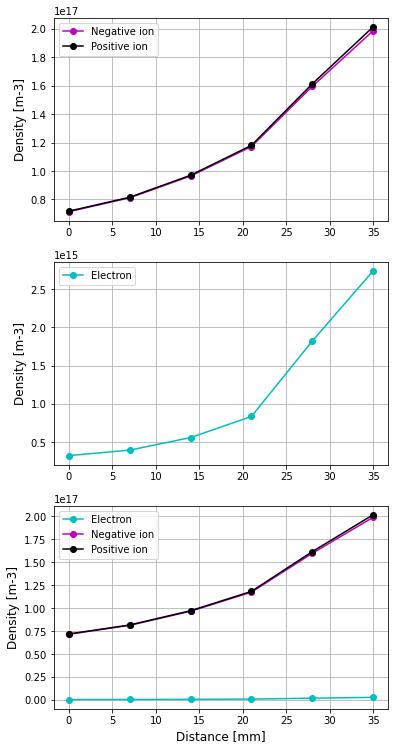

In [29]:
data_iter, data_fit = [], []

workDir = './211216(SF6)/bias (GND)/'
x_type = 'Distance'
parser = ldf.parser(workDir)
ldf_list = parser.ldf_paths()

for file in ldf_list:

    # Check file name
    print(file)


    # Parsing IV curve from ldf file
    IV, imported_eedf, result = parser.pull_attr(file, need_return=True)
    x = float(file.split('/')[-1][:-4])


    # Calculation x, Vsat, Isat, Vp, eepf, eedf, second_derivative from IV curve
    processor = ldf.processor(IV)
    Vsat, Isat = processor.cal_sat()
    Vp = processor.cal_Vp()
    energy, eepf, eedf = processor.cal_eepf()
    V, IV_second_derivative = processor.cal_second_derivative()


    # Plot EEPF and dIdV to determine energy range 
    plotting.plot_check(energy, eepf, processor.V, processor.dIdV, Vp)


    # Enter energy range for EEDF integration to get ne & Te
    print("Enter limited energy")
    V_lim = input()
    V_lim = np.float32(V_lim)


    # Calculation ne & Te from EEDF
    ne = processor.cal_ne(V_lim)
    Te = processor.cal_Te(ne, V_lim)
    print('ne: {:.3e} [m-3]\t Te: {:.3f} [eV] \t V_lim: {}'.format(ne, Te, V_lim))
    

    # Start Iterative method
    iter_1 = method.iterative(ne, Te, Vsat, Isat, Vp)
    alpha_iter = iter_1.iteration()
    nm = ne*alpha_iter
    #print("Iteration method \tVp: {}, Vsat: {}, Isat: {}\n\n".format(Vp, Vsat, Isat))
    data_iter.append((Vp, alpha_iter, Te, x, ne, nm))


    # Start Fitting method
    # fit_1 = method.fitting(IV, V, IV_second_derivative)
    # alpha_fit = fit_1.fitting()
    # nm = ne*alpha_fit
    # #print("Fitting method \tVp: {}, Vsat: {}, Isat: {}\n\n".format(Vp, Vsat, Isat))
    # data_fit.append((Vp, alpha_fit, Te, x, ne, nm))


# Plot results
df_iter = pd.DataFrame(data_iter, columns=['Vp', 'alpha', 'Te', 'x', 'ne', 'nm'])
plotting.plot_default(df_iter['x'], df_iter['Te'], df_iter['Vp'], df_iter['alpha'], df_iter['ne'], x_type=x_type, save=True)
plotting.plot_density(df_iter['x'], df_iter['ne'], df_iter['nm'], x_type=x_type, save=True)

# df_fit = pd.DataFrame(data_fit, columns=['Vp', 'alpha', 'Te', 'x', 'ne', 'nm'])
# plotting.plot_default(df_fit['x'], df_fit['Te'], df_fit['Vp'], df_fit['alpha'], df_fit['ne'])
# plotting.plot_density(df_fit['x'], df_fit['ne'], df_fit['nm'])